In [1]:
!qbraid jobs enable haqs # enable quantum jobs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [2]:
TEAM_NAME = "Qualition"

In [3]:
pip install quadprog


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import quadprog # A package that includes the quadratic programming solver solve_qp()

### Load data

In [5]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [6]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_test = 40
n_samples = 40 + n_test  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=n_test) #train_test_split was imported from sklearn.model_selection
n_train = X_train.shape[0]
n_test = X_test.shape[0]
t = Y_train # A convenient renaming. The letter t for "targets"

### Build kernel

In [7]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

In [8]:
def kernel_gates(x1,x2):
    """Short depth feature map with entanglement

    Args:
        x1 : shape (3,) tensor containing one encoded data vector
        x2 : same
    """
    
    # the circuit for calculating the inner product between x1 and x2. No simplifications implemented.
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(-2 * x1[0], wires=0)
    qml.RZ(-2 * x1[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * x1[2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(-2 * x1[0], wires=0)
    qml.RZ(-2 * x1[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * x1[2], wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.CNOT(wires=[0, 1])
    qml.RZ(2 * x2[2], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(2 * x2[1], wires=1)
    qml.RZ(2 * x2[0], wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)
    
    qml.CNOT(wires=[0, 1])
    qml.RZ(2 * x2[2], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(2 * x2[1], wires=1)
    qml.RZ(2 * x2[0], wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)

In [9]:
def kernel_circuit(x1, x2):
    """Havlicek et al. variational quantum circuit

    Args:
        x1 and x2 : shape (2,) tensors each containing one input data vector

    Returns:
        shape(2**2,) tensor containing Z basis measurement probability on each qubit
    """

    kernel_gates(encode_data(x1),encode_data(x2))
    
    return qml.sample(op=qml.Hermitian(np.outer([1,0,0,0],[1,0,0,0]),wires=[0,1]))

In [10]:
# Prepare qnode using local simulator device
shots = 2*10**6 # Note the probabilities returned from qnode_local will be estimates based on {shots} samples
dev_local = qml.device("default.qubit", wires=2, shots=shots)
qnode_local = qml.QNode(kernel_circuit, dev_local)

### Estimate kernel

In [11]:
def kernel(X1, X2):
    """
    This function calculates the kernel entries between all the datapoints in X1 and X2.
    It returns them as an array with dimensions (len(X1), len(X2)).
    """
    
    if np.all(X1 == X2): # save half the time when kernel is symmetric
        
        kernel = 0.5*np.eye(len(X1)) # initialize kernel array

        # calculate off-diagonals
        for (i1, x1), (i2,x2) in tqdm(combinations(enumerate(X1), 2),
                                      desc='calculating off-diagonals',
                                      leave=False,
                                      total=int(len(X1)*(len(X1) - 1)/2)):
            samples = qnode_local(x1, x2)
            kernel[i1, i2] = np.sum(samples)/shots
            
        kernel = kernel + kernel.T
        
        return kernel
    
    else:
        
        kernel = np.zeros((len(X1), len(X2)))
        for (i1, x1) in tqdm(enumerate(X1),
                             desc='calculating kernel',
                             leave=False,
                             total=len(X1)):
            for (i2, x2) in enumerate(X2):
                samples = qnode_local(x1, x2)
                kernel[i1, i2] = np.sum(samples)/shots
        return kernel

In [12]:
K = kernel(X_train, X_train) # estimate kernel

calculating off-diagonals:   0%|          | 0/780 [00:00<?, ?it/s]

The above is only an estimate of the true kernel. While the true kernel is positive semidefinite, the estimated kernel is unlikely to be. We will replace the estimated kernel with a nearby positive definite matrix. We do this by replacing all eigenvalues below some small tolerance with a small positive value. This accounts for both the shot noise and machine imprecision.

In [13]:
# find a close positive definite matrix
vals, vecs = np.linalg.eigh(K) # get eigenvalues and eigenvectors of the kernel estimate
tol = 5*10**-15 # A tolerance for how small the smallest eigenvalue should be
vals[vals < tol] = tol # replace small eigenvalues with cutoff value
K_safe = vecs*vals @ vecs.conj().T # K_safe is positive definite

### Solve SVM

Find coefficients $a_n$ that minimize $L_D = \sum_na_n - \frac{1}{2}\sum_{n,m}a_na_mt_nt_mK_{nm}$ given the constraints $a_n\geq 0$ and $\sum_n a_nt_n=0$, where $t_n$ are the target classes. (Note we impose no upper bound on the $a_n$ because we know the classes can be perfectly separated by a hyperplane in feature space.)

This is a quadratic programming problem. To solve it we use the `solve_qp()` method of the `quadprog` package. The call `solve_qp(Q, p, A, c, meq=n)` will minimize the quantity $\frac{1}{2} x^T Q x - p^T x$ where the first $n$ rows of $A^T x - c$ are constrained to be equal to zero and the rest of the rows are constrained to be greater than or equal to zero. Applied to our problem, $Q_{nm} = t_nt_mK_{nm}$, $p = \begin{bmatrix}1\\ \vdots \\ 1\end{bmatrix}$, $A = \begin{bmatrix} t\ |\ I \end{bmatrix}$, $c = \vec{0}$, and $n = 1$. Finally, the entries of the output $x$ are the vector of coefficients $a_n$.

In [14]:
# Use quadprog package to solve the quadratic programming problem.
Q = ((t * (K_safe)).T * t).T # This has entries t_n * t_m * K_nm
p = np.full(n_train, 1, dtype=float)
A = np.column_stack((t, np.eye(n_train, dtype=float)))
c = np.zeros(n_train + 1, dtype=float)
sol = quadprog.solve_qp(Q, p, A, c, meq=1)
a = sol[0] # The coefficients a_n

Most of the coefficients $a_n$ will be zero (to within some tolerance). These correspond to datapoints that are not near the boundary between the classes and whose exact positions are not important to the model. The remainder of the datapoints are the support vectors.

In [15]:
# Pick out support vectors and targets
tol = 10**(-7) # cutoff for identifying coefficients a[i] as zero
ind_sup = a > tol # indices of support vectors
a_sup = a[ind_sup] # dual coefficients for support vectors
t_sup = Y_train[ind_sup] # the targets of support vectors
n_sup = sum(ind_sup) # number of support vectors
print(f'There are {n_sup} support vectors out of {n_train} training vectors.')

There are 15 support vectors out of 40 training vectors.


### Build prediction function

The SVM model predicts the class of $\vec{x}$ to be $\operatorname{sign}(\sum_na_nt_nk(\vec{x},\vec{x}_n) + b)$. Here $b= \frac{1}{n_{\text{sup}}}\left(\sum_nt_n - \sum_{n,m} a_mt_mk(x_n, x_m) \right)$ where all the sums are over only support vectors and $n_{\text{sup}}$ is the number of support vectors.

In [16]:
# Calculate the bias b.
b = float(
    (
     np.sum(t_sup)
     - np.sum(a_sup * t_sup * K_safe[:,ind_sup][ind_sup])
    )/n_sup
    )

# Define the model's classification function
def classify(X):
    """
    This function takes as input datapoints X and outputs their predicted classifications.
    """
    
    # Estimate kernel entries between test datapoints and support datapoints
    K_test = kernel(X, X_train[ind_sup])
    
    y = np.sum(a[ind_sup] * t[ind_sup] * K_test, axis=1) + b
    
    return np.sign(y)

### Test accuracy

In [17]:
# Predict test data classifications
Y_pred = classify(X_test)

# Check against targets.
preds = [1 if Y_pred[i] == Y_test[i] else 0 for i in range(len(Y_pred))]

n_preds = len(Y_pred)
n_correct = sum(preds)
n_incorrect = n_preds - n_correct
accuracy = n_correct / n_preds

print(f"Accuracy: {round(accuracy*100,2)}%")
print(f"{n_incorrect} incorrect out of {n_preds}.")

calculating kernel:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 100.0%
0 incorrect out of 40.


### Visualizations of the model

We will plot the decision boundary of our model as well as the $\pm 1$ margins on which the support vectors should lie.

In [18]:
# Hard code the exact formula for the kernel entries, for speed and accuracy of visualization
# In reality, the model's placement of the boundary is probabilistic as kernel values are the result of sampling.
def K_exact(z1, z2):
    x1 = encode_data(z1)
    x2 = encode_data(z2)
    a0 = np.exp(-2j*(x1[1] + x1[2]))
    a1 = np.exp(-2j*(x1[0] + x1[2]))
    a2 = np.exp(-2j*(x1[0] + x1[1]))
    b0 = np.exp(2j*(x2[1] + x2[2]))
    b1 = np.exp(2j*(x2[0] + x2[2]))
    b2 = np.exp(2j*(x2[0] + x2[1]))
    
    k = np.abs(1/16*((1 + a0 + a1 + a2)*(1 + b0 + b1 + b2)
                     + a0*b0*(1 - a0 + a1 - a2)*(1 - b0 + b1 - b2)
                     + a1*b1*(1 + a0 - a1 - a2)*(1 + b0 - b1 - b2)
                     + a2*b2*(1 - a0 - a1 + a2)*(1 - b0 - b1 + b2)))**2
    
    return k

In [19]:
# Prepare mesh for contour plot
x1_vals = np.linspace(0, 2*np.pi, 120)
x2_vals = np.linspace(0, 2*np.pi, 120)
X2, X1 = np.meshgrid(x1_vals, x2_vals)

# Classification function sampled at mesh points
Y = np.zeros(X1.shape)
for i, x1 in tqdm(enumerate(x1_vals), desc='calculating heights for contour plot', leave=False, total=len(X1)):
    for j, x2 in enumerate(x2_vals):
        K_sup = np.array([K_exact([x1, x2], x_sup) for x_sup in X_train[ind_sup]])
        Y[i, j] = np.sum(a[ind_sup] * t[ind_sup] * K_sup) + b

calculating heights for contour plot:   0%|          | 0/120 [00:00<?, ?it/s]

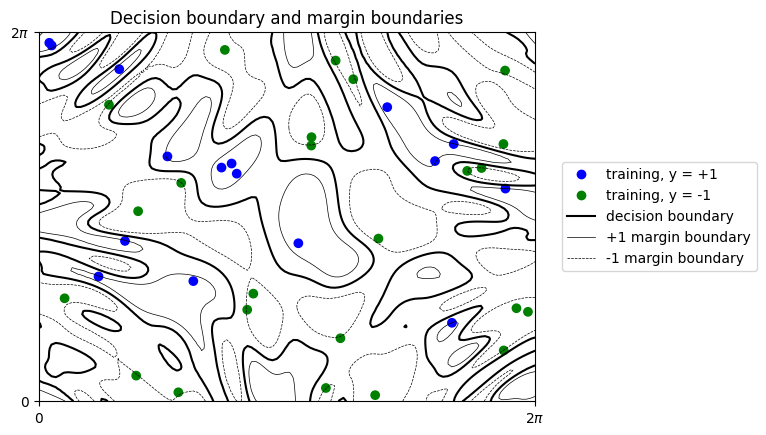

In [20]:
# Plot predictions

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

# Plot training points and classification boundary

label_plus = mlines.Line2D([], [], color="none", marker="o", markerfacecolor="b", markeredgecolor="b", label=f"training, y = +1")
label_minus = mlines.Line2D([], [], color="none", marker="o", markerfacecolor="g", markeredgecolor="g", label=f"training, y = -1")
label_0 = mlines.Line2D([0,1], [0,0], linewidth=1.5, linestyle='-', color="k", label=f"decision boundary")
label_solid = mlines.Line2D([0,1], [0,0], linewidth=0.5, linestyle='-', color="k", label=f"+1 margin boundary")
label_dashed = mlines.Line2D([0,1], [0,0], linewidth=0.5, linestyle='--', color="k", label=f"-1 margin boundary")
# dash_capstyle=None, solid_capstyle=None, dash_joinstyle=None, solid_joinstyle=None, pickradius=5, drawstyle=None, markevery=None, **kwargs

contours = plt.contour(X1, X2, Y, (-1, 0, 1), linewidths=(0.5, 1.5, 0.5), colors='black')
# plt.scatter(xi, xj, marker="o", c=["r" if v == 1 else "b" for v in Ys])
# plt.scatter(xi_test, xj_test, c=["y" if v == 1 else "r" for v in preds])
plt.scatter(xi_train, xj_train, c=["b" if v == 1.0 else "g" for v in Y_train])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.legend(handles=[label_plus, label_minus, label_0, label_solid, label_dashed], bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.title(f"Decision boundary and margin boundaries")
plt.show()

The thick line in the above plot its the boundary between different classifications assigned by the model. The thin lines are the margins on which the support vectors lie. The dashed thin line is the -1 margin, and the solid thin line is the +1 margin.

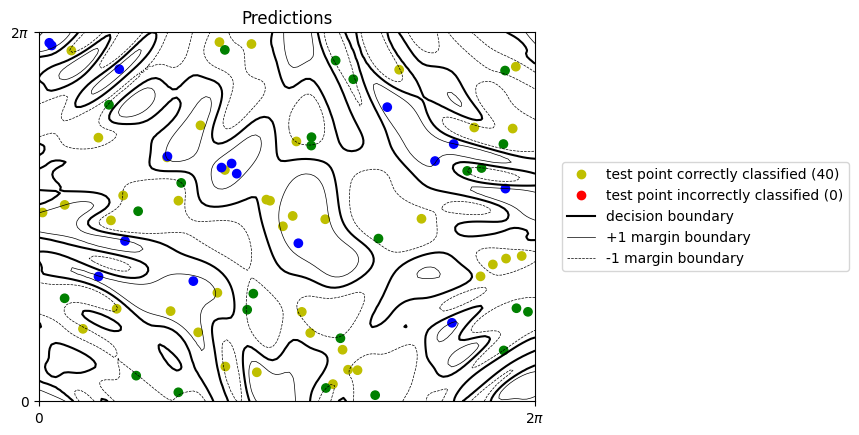

In [21]:
# Plot testing points and classification boundary

label_correct = mlines.Line2D([], [], color="none", marker="o", markerfacecolor="y", markeredgecolor="y", label=f"test point correctly classified ({n_correct})")
label_incorrect = mlines.Line2D([], [], color="none", marker="o", markerfacecolor="r", markeredgecolor="r", label=f"test point incorrectly classified ({n_incorrect})")

plt.contour(X1, X2, Y, (-1, 0, 1), linewidths=(0.5, 1.5, 0.5), colors='black')
# plt.scatter(xi, xj, marker="o", c=["r" if v == 1 else "b" for v in Ys])
plt.scatter(xi_test, xj_test, c=["y" if v == 1 else "r" for v in preds])
plt.scatter(xi_train, xj_train, c=["b" if v == 1.0 else "g" for v in Y_train])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.legend(handles=[label_correct, label_incorrect, label_0, label_solid, label_dashed], bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.title(f"Predictions")
plt.show()

This plot includes the test datapoints in yellow and red. Misclassified datapoints are in red.

### Comparison of model to data generator

Our model finds a hyperplane in feature space that separates the data into classes. The data was itself generated using some choice of hyperplane in feature space. We will compare the decision boundary of our model with the boundary used to generate the data.

In [22]:
# Extract parameters used to generate the data

def parse_param(f):
    """
    This function takes as input the str() version of a numpy array and outputs the original numpy array.
    """
    f = f.replace('\n ', '') # Remove newlines
    f = f.replace('\n', '')
    
    if 'j' in f: # check for complex type
        f = f.replace('j', 'j,') # Add commas between entries within rows
    else:
        f = f.replace('  ', ',').replace(' +', ',+').replace(' -', ',-') # Add commas between entries within rows
        f = f.replace(' ', ',')
        f = f.replace('[,', '[').replace(',]', ']').replace(',,', ',') #.replace(',-', '-') # remove extraneous commas
    
    f = f.replace('][', '],[') # Add commas between rows
    
    f = np.array(eval(f))
    
    return f

# Extract parameters
f = parse_param(params['f'])
V = parse_param(params['V'])

In [23]:
# The observable whose expectation value determined the classification when the data was generated
observable = qml.Hermitian(np.conj(V).T @ f @ V, wires=[0,1])

# Prepares state in feature space and returns expectation value of op
def gen_classify_circuit(z):
    
    x = encode_data(z)
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(-2 * x[0], wires=0)
    qml.RZ(-2 * x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * x[2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.RZ(-2 * x[0], wires=0)
    qml.RZ(-2 * x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(-2 * x[2], wires=1)
    qml.CNOT(wires=[0, 1])

    return qml.expval(observable)

In [24]:
# Prepare qnode for exact calculation
dev_exact = qml.device("default.qubit", wires=[0,1])
qnode_exact = qml.QNode(gen_classify_circuit, dev_exact)

In [25]:
# Prepare mesh for contour plot
x1_vals = np.linspace(0, 2*np.pi, 120)
x2_vals = np.linspace(0, 2*np.pi, 120)
X2, X1 = np.meshgrid(x1_vals, x2_vals)

# Classification function sampled at mesh points
Y_gen = np.zeros(X1.shape)
for i, x1 in tqdm(enumerate(x1_vals), desc='calculating heights for contour plot', leave=False, total=len(X1)):
    for j, x2 in enumerate(x2_vals):
        Y_gen[i, j] = qnode_exact([x1, x2])/delta # We divide by the separation so that the margins are at +/-1

calculating heights for contour plot:   0%|          | 0/120 [00:00<?, ?it/s]

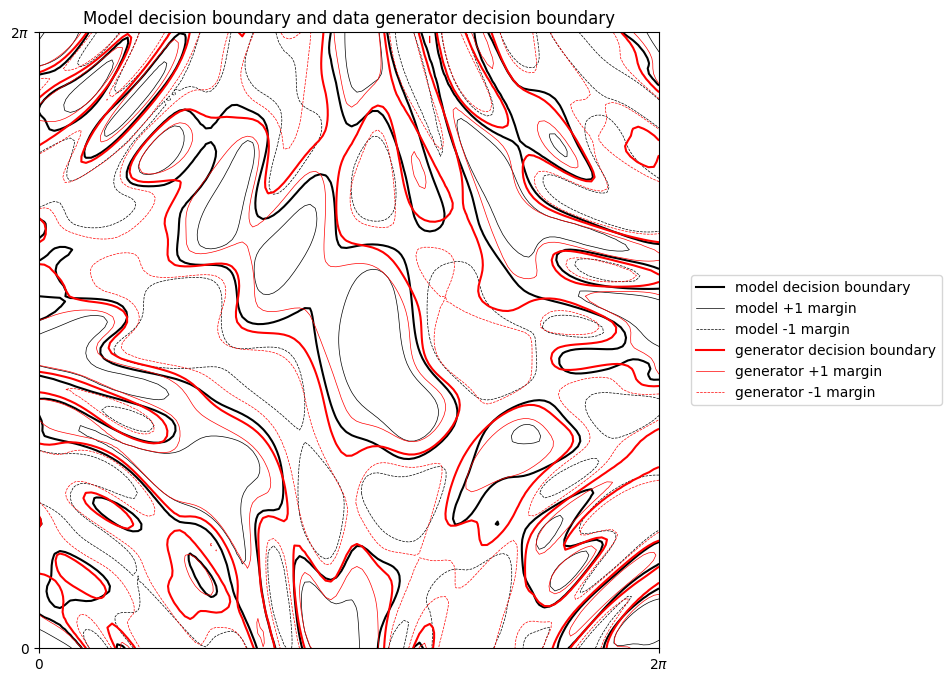

In [26]:

label_0_model = mlines.Line2D([0,1], [0,0], linewidth=1.5, linestyle='-', color="k", label=f"model decision boundary")
label_solid_model = mlines.Line2D([0,1], [0,0], linewidth=0.5, linestyle='-', color="k", label=f"model +1 margin")
label_dashed_model = mlines.Line2D([0,1], [0,0], linewidth=0.5, linestyle='--', color="k", label=f"model -1 margin")
label_0_gen = mlines.Line2D([0,1], [0,0], linewidth=1.5, linestyle='-', color="r", label=f"generator decision boundary")
label_solid_gen = mlines.Line2D([0,1], [0,0], linewidth=0.5, linestyle='-', color="r", label=f"generator +1 margin")
label_dashed_gen = mlines.Line2D([0,1], [0,0], linewidth=0.5, linestyle='--', color="r", label=f"generator -1 margin")


plt.figure(figsize=(8,8))

contours = plt.contour(X1, X2, Y, (-1, 0, 1), linewidths=(0.5, 1.5, 0.5), colors='black')
contours_gen = plt.contour(X1, X2, Y_gen, (-1, 0, 1), linewidths=(0.5, 1.5, 0.5), colors='r')
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.legend(handles=[label_0_model, label_solid_model, label_dashed_model, label_0_gen, label_solid_gen, label_dashed_gen], bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.title(f"Model decision boundary and data generator decision boundary")
plt.show()

We see in the above figure how the model classifies points versus how the original function generating data classifies points. Though they largely match, occasionaly the boundaries of the original classification regions (the thin red lines) cross the model decision boundary (thick black line). When this happens, any test datapoints that happen to be there will be misclassified. To better visualize this point, see the following plot:

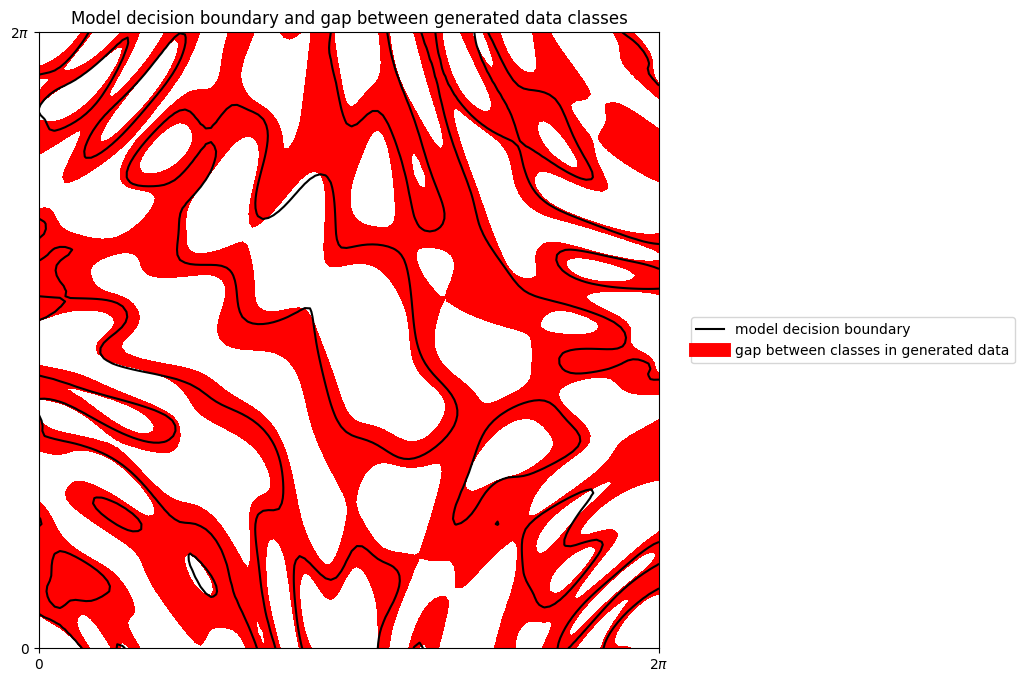

In [27]:
label_0_gap = mlines.Line2D([0,1], [0,0], linewidth=10, linestyle='-', color="r", label=f"gap between classes in generated data")

plt.figure(figsize=(8,8))

contours_gen = plt.contourf(X1, X2, Y_gen, (-1, 1), colors='r')
contours = plt.contour(X1, X2, Y, (0), linewidths=(1.5), colors='black')
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.legend(handles=[label_0_model, label_0_gap], bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.title(f"Model decision boundary and gap between generated data classes")
plt.show()

In this plot we see the model decision boundary as well as the gap between the two classes of generated data. For the most part, the decision boundary lies within this gap, but occasionally it ventures out. In such cases datapoints between the decision boundary and the red band would be misclassified.

### Comparisons to true kernel

In [28]:
# Build true kernel
K_true = 0.5*np.eye(len(X_train))

for (i1, x1), (i2,x2) in tqdm(combinations(enumerate(X_train), 2),
                              desc='calculating off-diagonals',
                              leave=False,
                              total=int(n_train*(n_train - 1)/2)):
    K_true[i1, i2] = K_exact(x1, x2)

K_true = K_true + K_true.T

calculating off-diagonals:   0%|          | 0/780 [00:00<?, ?it/s]

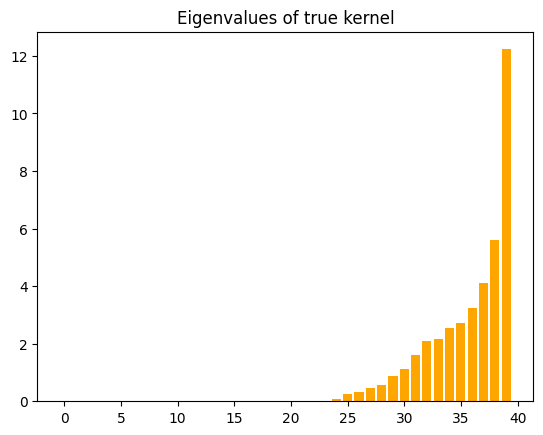

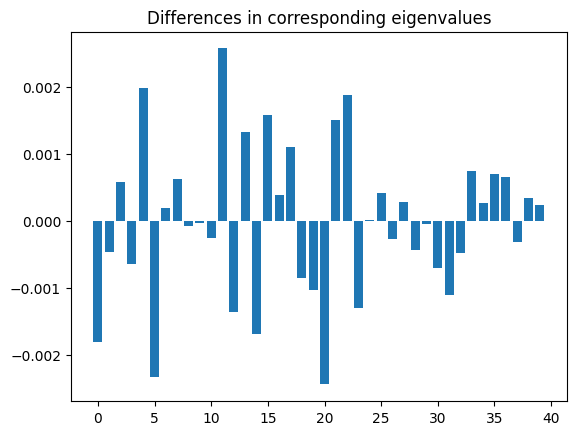

In [29]:
# get eigenvalues and eigenvectors for both
vals, vecs = np.linalg.eigh(K)
vals_true, vecs_true = np.linalg.eigh(K_true)

# Overlaps of K_true eigenvectors with K eigenvectors
comp = np.abs(vecs_true.conj().T @ vecs)**2

# Order the eigenvalues of K to corresponding eigenvalues of K_true
order = []
for i in range(n_train):
    found = False
    while not found:
        ind = np.argmax(comp[:,-i-1])
        if ind not in order:
            order.append(ind)
            found = True
        else:
            comp[ind,-i-1] = 0    
order.reverse()
vals_ordered = vals[order]

# Plot eigenvalues of true kernel
plt.bar(range(n_train), vals_true, color='orange')
plt.title('Eigenvalues of true kernel')
plt.show()

# Plot difference in eigenvalues
plt.bar(range(n_train), vals_ordered - vals_true)
plt.title('Differences in corresponding eigenvalues')
plt.show()

The second above plot shows the differences between the eigenvalues of the true kernel and the eigenvalues of the estimated kernel. We matched eigenvalues of one with the other by comparing the overlaps of the eigenvectors of the two kernels. The first plot above is simply the eigenvalues of the true kernel. Note that the eigenvalues which are zero (to machine precision) in the true kernel become both positive and negative with magnitude on the order of $1/\sqrt{R}$ where $R$ is the number of shots. This deviation from zero makes the estimated kernel non positive-semidefinite and is the reason we must replace `K` with `K_safe`.

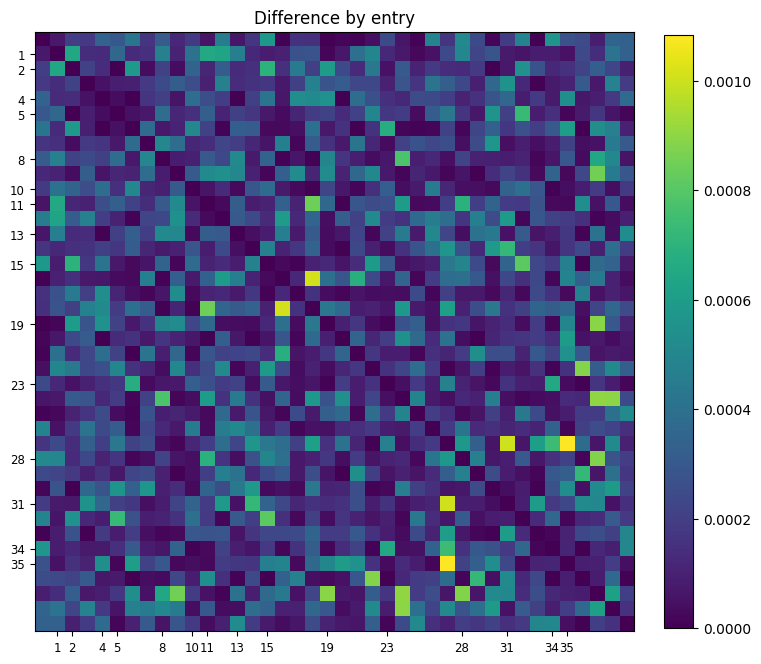

In [30]:
fig, ax = plt.subplots(figsize=(8.5,8.5))
im = ax.imshow(np.abs(K_true - K))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(n_train)[ind_sup], np.arange(n_train)[ind_sup], fontsize=8.5)
ax.set_yticks(np.arange(n_train)[ind_sup], np.arange(n_train)[ind_sup], fontsize=8.5)
ax.set_title("Difference by entry")
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.045)
plt.show()

The above figure shows the absolute difference between entries of the true kernel and the estimated kernel. The columns and rows corresponding to support vectors are labeled.